# Decision Trees and Random Forests

## Decision Trees

We will have a look at the `Carseats` data using the `tree` package in R, as in the lab in the book.

We create a binary response varable `High` (for high sales), and we include it in the same dataframe.

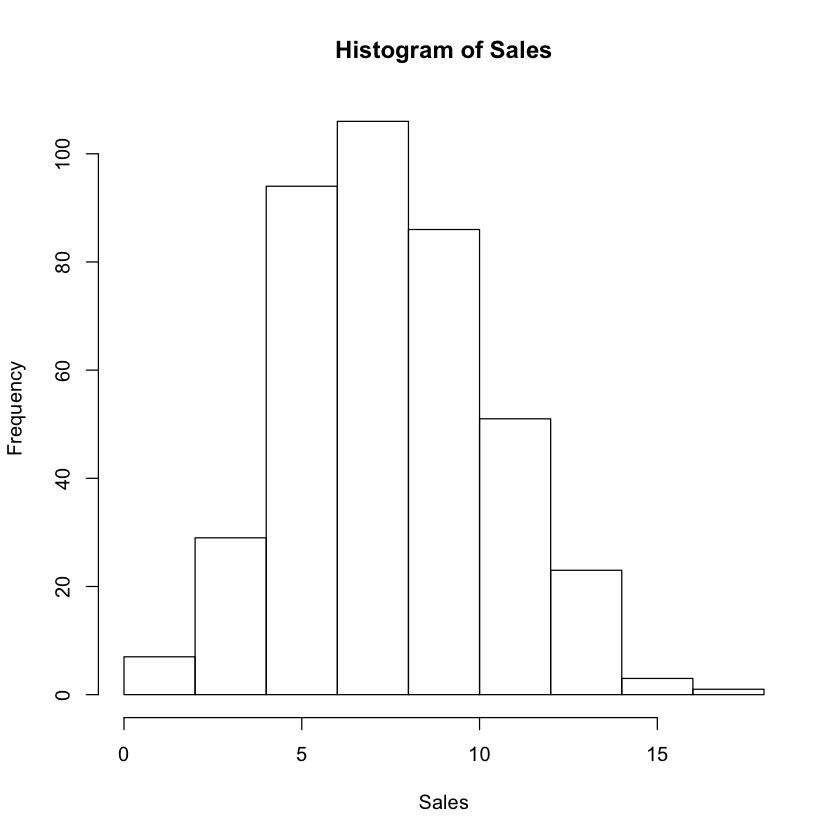

In [3]:
library(ISLR)
library(tree)
attach(Carseats)
hist(Sales)
High=ifelse(Sales<=8, "No", "Yes")
Carseats=data.frame(Carseats, High)

We now fit a tree to these data, and summarize and plot it. Notice that we have to _exclude_ `Sales` from the right-hand side of the formula, because the response is derived from it.


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

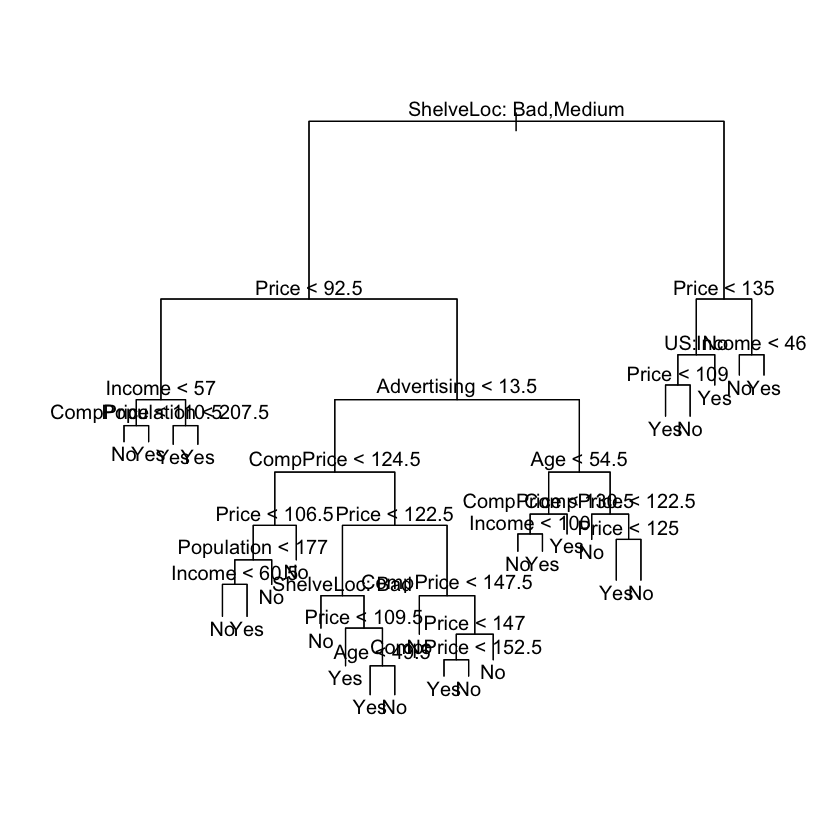

In [4]:
tree.carseats=tree(High~.-Sales, data=Carseats)
summary(tree.carseats)
plot(tree.carseats)
text(tree.carseats, pretty = 0)

In [5]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

         High
tree.pred No Yes
      No  72  23
      Yes 15  40

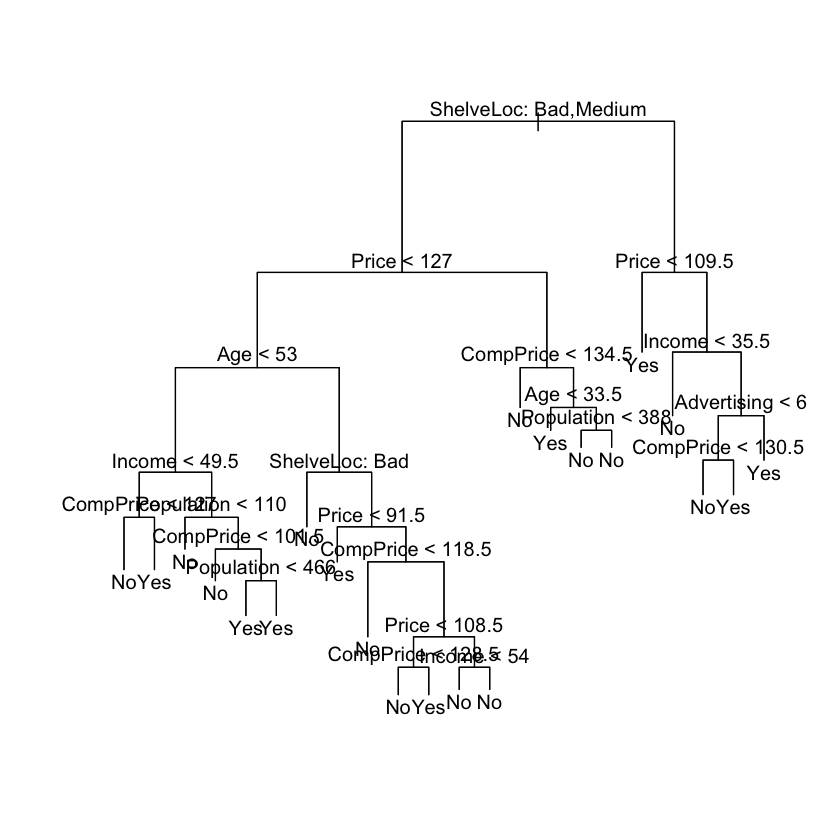

In [7]:
set.seed(1)
train = sample(1:nrow(Carseats), 250)
tree.carseats = tree(High~.-Sales, Carseats, subset = train)
plot(tree.carseats); text(tree.carseats, pretty = 0)
tree.pred=predict(tree.carseats, Carseats[-train,], type = 'class')
with(Carseats[-train,], table(tree.pred, High))

In [8]:
(72 + 40) / 150

[1] 0.7466667

This tree was grown to full depth, and might be too variab;e. We now use CV to prune it.

$size
 [1] 22 19 17 15 14 10  8  7  5  4  2  1

$dev
 [1]  62  62  59  59  64  64  66  68  67  70  80 101

$k
 [1]  -Inf  0.00  0.50  1.00  2.00  2.25  2.50  3.00  3.50  6.00  8.00 27.00

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

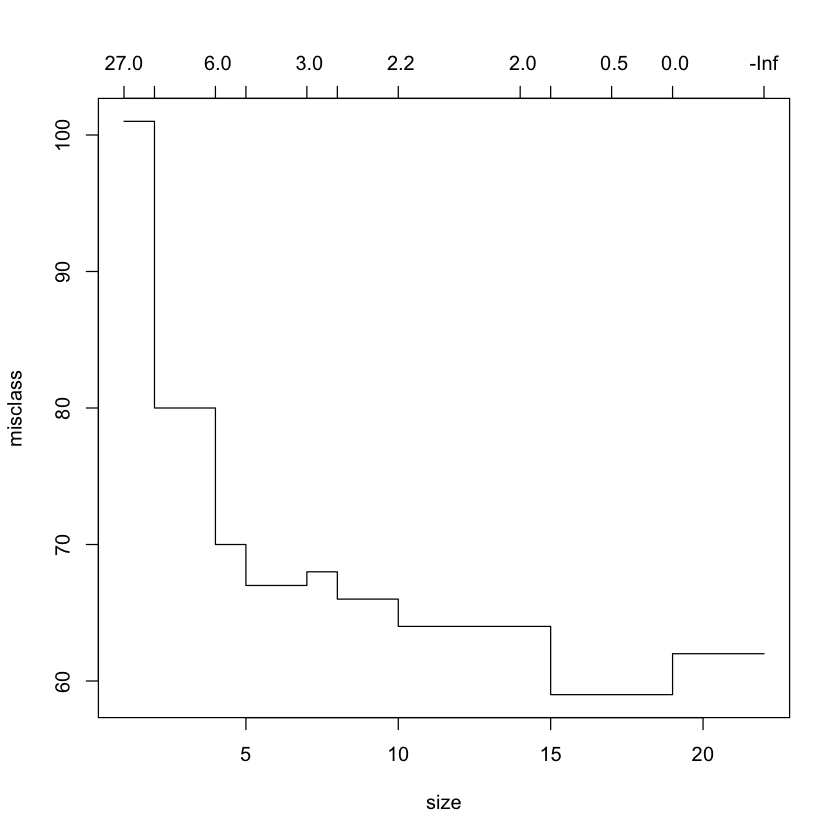

In [9]:
cv.carseats=cv.tree(tree.carseats, FUN=prune.misclass)
cv.carseats
plot(cv.carseats)

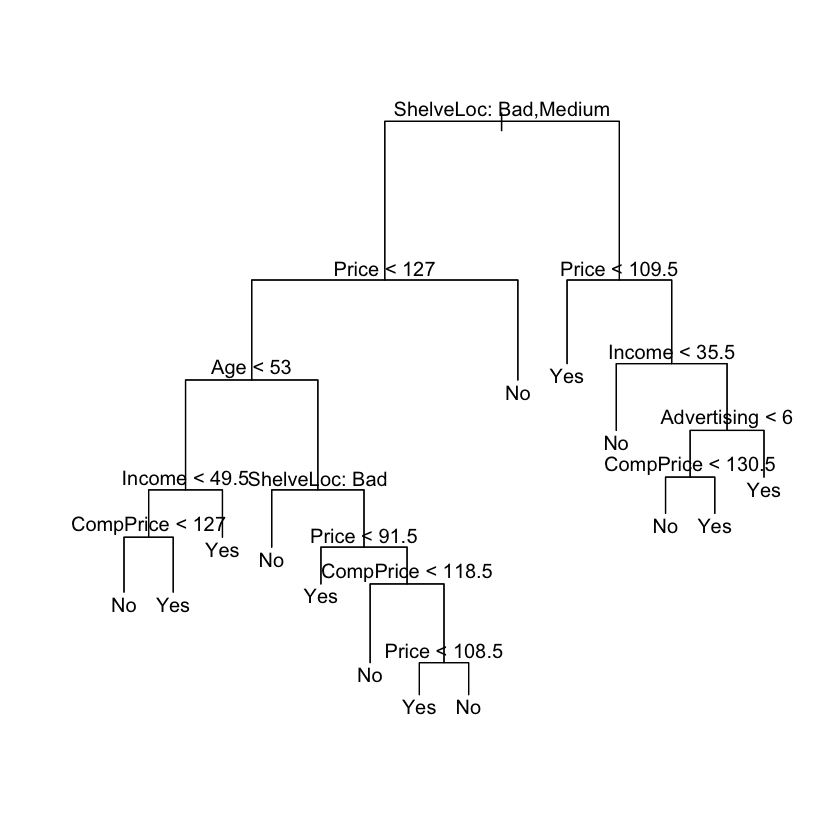

In [17]:
prune.carseats=prune.misclass(tree.carseats, best = 13)
plot(prune.carseats); text(prune.carseats, pretty = 0)

Now lets evaluate this pruned tree on the test data

In [18]:
tree.pred=predict(prune.carseats, Carseats[-train,], type = 'class')
with(Carseats[-train,], table(tree.pred, High))

         High
tree.pred No Yes
      No  69  15
      Yes 18  48

In [19]:
(69+48) / 150

[1] 0.78

## Random Forest and Boosting

This method uses trees as building blocks to build more complex models. Here we will use the Boston housing data to explore random forests and boosting. These data are in the `MASS` package.

It gives housing values and other statistics in each of 506 suburbs of Boston based on a 1970 census.

### Random Forests

Random forests build lots of bushy trees, and then average them to reduce the variance.

In [23]:
library(randomForest)
library(MASS)
set.seed(101)
dim(Boston)
train=sample(1:nrow(Boston), 300)
?Boston

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


[1] 506  14

Lets fit a random forest and see how well it perform. We will use the response `medv`, the median housing value (in \$1k dollars)

In [24]:
rf.boston=randomForest(medv~.,data=Boston, subset = train)
rf.boston


Call:
 randomForest(formula = medv ~ ., data = Boston, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 12.68651
                    % Var explained: 83.45

The MSR and % variance explained are based on OOB or Out-Of-Bag estimates, a very clever device in random forests to get honest error estimates. The model reports that `mtry=4`, which is the number of variables radomly chosen at each split. Since $p=13$ here, we could try all 13 possible values of `mtry`. We will do so, record the result, and make a plot.

1 2 3 4 5 6 7 8 9 10 11 12 13 

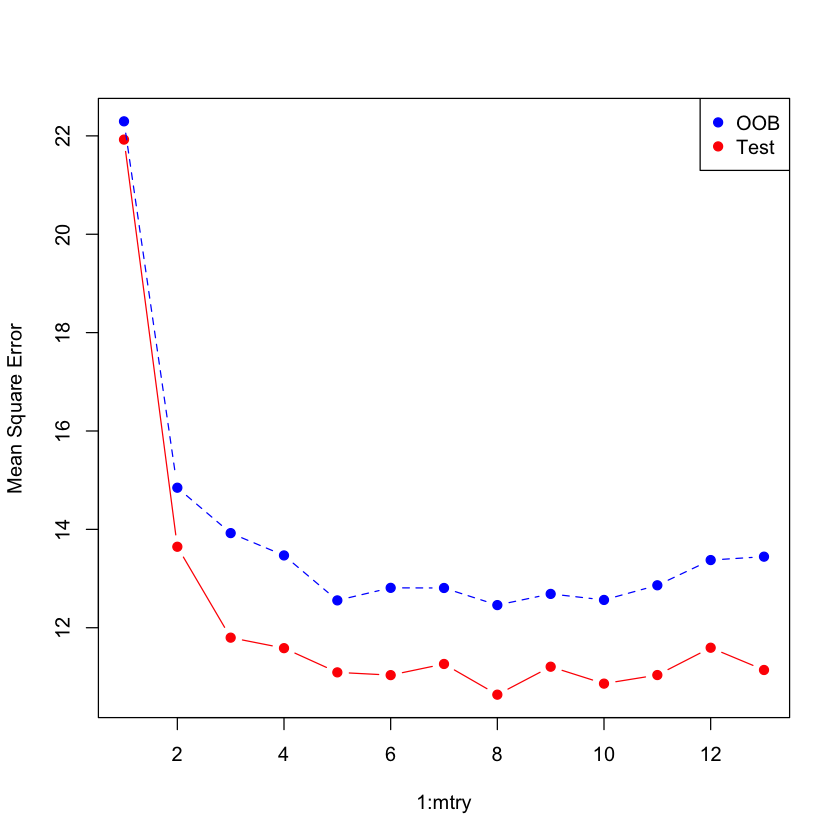

In [38]:
oob.err=double(13)
test.err=double(13)
for(mtry in 1:13){
    fit=randomForest(medv~.,data=Boston, subset = train,mtry=mtry, ntree=400)
    oob.err[mtry]=fit$mse[400]
    pred=predict(fit, Boston[-train,])
    test.err[mtry] = with(Boston[-train,], mean((medv - pred)^2))
    cat(mtry, "")
}

matplot(1:mtry, cbind(test.err, oob.err), pch=19, col=c('red', 'blue'),type='b', ylab='Mean Square Error')
legend('topright', legend=c('OOB', 'Test'), pch=19, col=c('blue', 'red'))

Notice that the points at the end with `mtry=13` correspond to bagging

### Boosting

Boosting builds lots of smaller trees, Unlike random forests, each new tree in boosting tries to patchup the deficiencies of the current ensemble.

,var,rel.inf
,<fct>,<dbl>
lstat,lstat,35.58827757
rm,rm,29.49456458
dis,dis,9.30617134
crim,crim,5.81566357
age,age,5.03288962
nox,nox,4.36655313
black,black,3.31266605
ptratio,ptratio,2.64583373
tax,tax,2.15387766


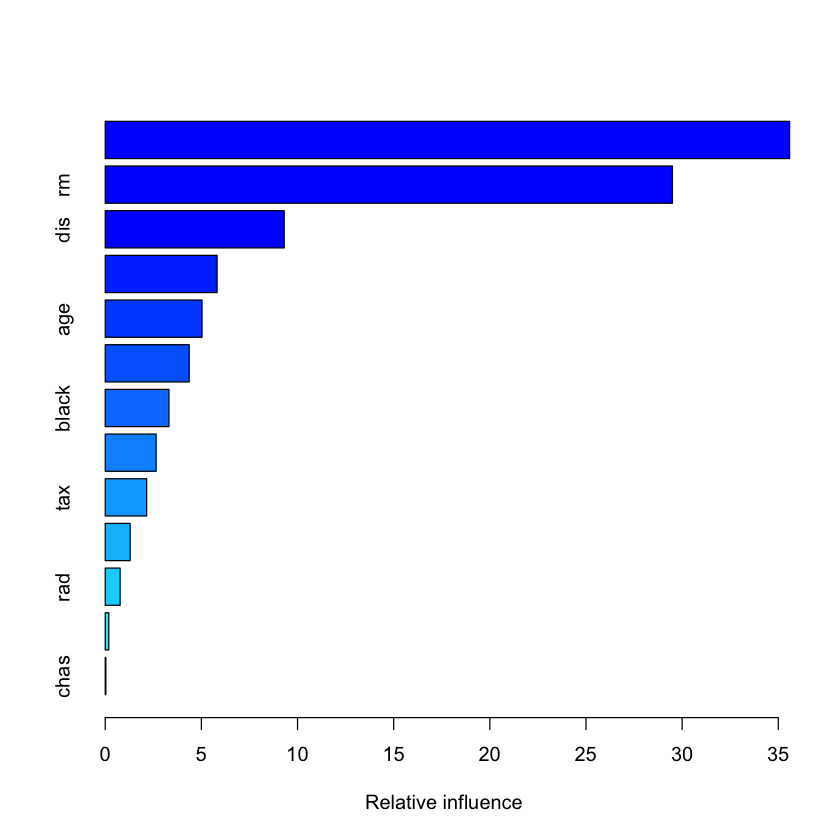

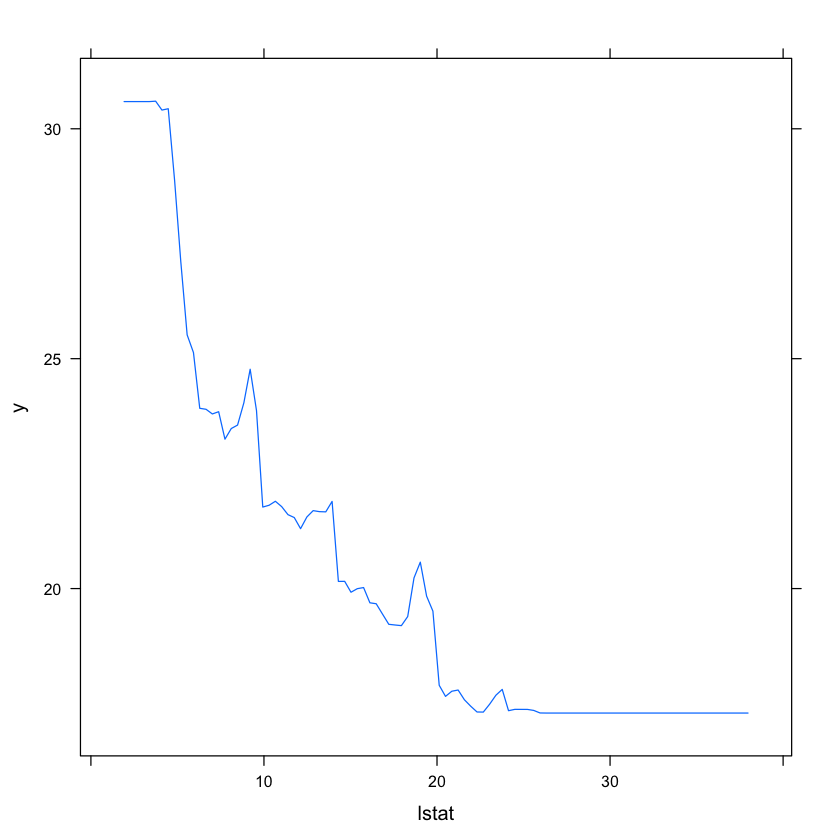

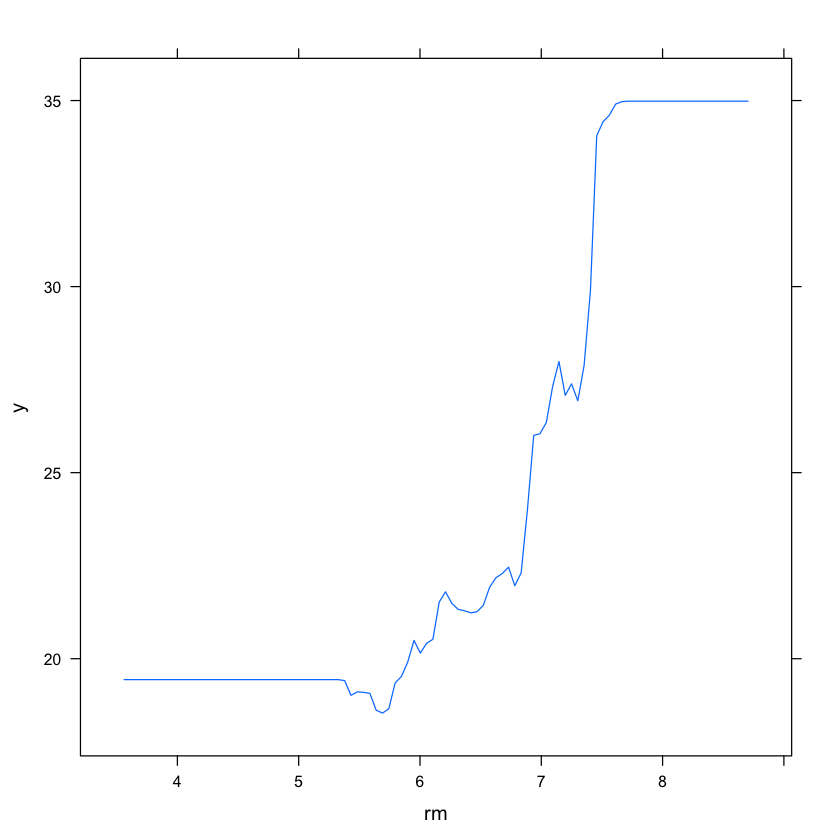

In [39]:
library(gbm)
boost.boston=gbm(medv~.,data=Boston[train,], distribution='gaussian', n.tree=10000, shrinkage=0.01, interaction.depth=4)
summary(boost.boston)
plot(boost.boston, i='lstat')
plot(boost.boston, i='rm')

Lets make a prediction on the test set. With boosting, the number of trees is a tuning parameter, and if we have too many we can overfit. So we should use cross validation to select the number of trees. We will leave this as an exercise. Instead, we will compute the test error as a function of the number of trees, and make a plot.

[1] 206 100

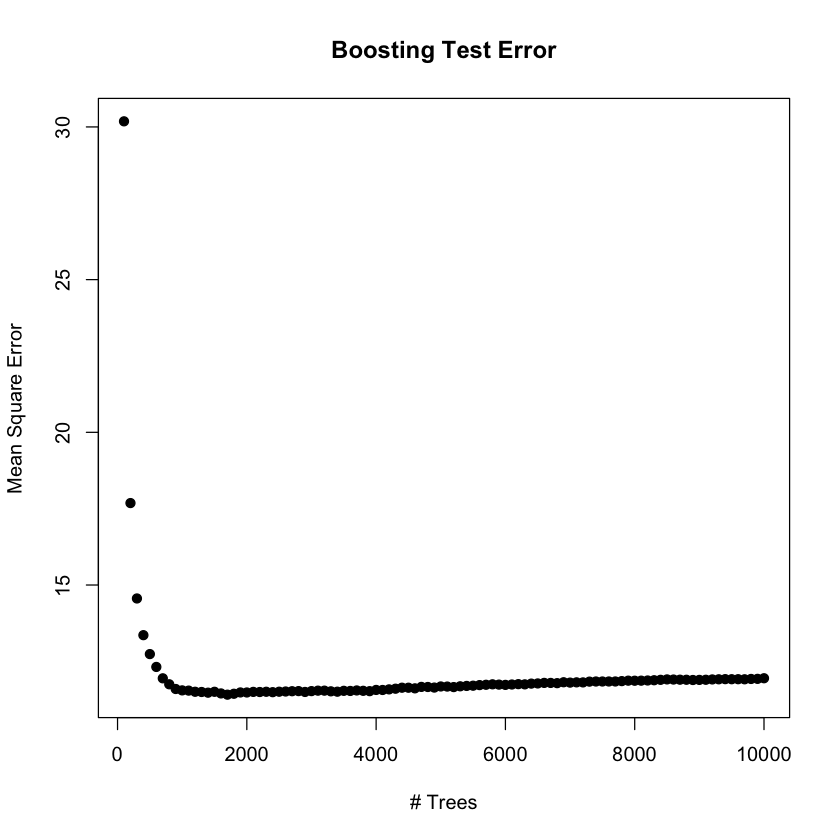

In [41]:
n.trees = seq(from=100,to=10000,by=100)
predmat=predict(boost.boston, newdata=Boston[-train,], n.trees = n.trees)
dim(predmat)
beer=with(Boston[-train,], apply((predmat - medv)^2, 2, mean))
plot(n.trees, beer, pch=19, ylab='Mean Square Error', xlab='# Trees', main='Boosting Test Error')